# The Method

In [18]:
!pip install activeSVC==1.0.1


In [1]:
import numpy as np
import time
import random
import os

from sklearn.preprocessing import normalize 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import gridspec

from activeSVC import min_complexity, min_acquisition
import pandas as pd
import pickle

def text_create(path, name, msg):
    full_path = path + "/" + name + '.txt'
    file = open(full_path, 'w')
    file.write(str(msg))

class TimerError(Exception):
     """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Total run time: {elapsed_time:0.4f} seconds")
        


# Download and Load Tabula Muris Data

In [4]:
import urllib.request
import shutil

with urllib.request.urlopen("https://caltech.box.com/shared/static/p2bjcw4ym5ow22yc5h2ld4d7m5wzrw8t.pickle") as response, open('./tabula.pickle', "wb") as out_file:
    shutil.copyfileobj(response, out_file)


In [3]:
import pickle
with open('tabula.pickle','rb') as handle:
    raw_data = pickle.load(handle)
    gene=np.array(pickle.load(handle))
    target=np.array(pickle.load(handle))


data=normalize(np.transpose(raw_data),axis=1, norm='l2')

del raw_data

idx = np.arange(np.shape(data)[0])
random.shuffle(idx)
X_train = data[idx[:int(np.shape(data)[0]*4/5)],:]
y_train = target[idx[:int(np.shape(data)[0]*4/5)]]
X_test = data[idx[int(np.shape(data)[0]*4/5):],:]
y_test = target[idx[int(np.shape(data)[0]*4/5):]]

print(np.shape(data),np.shape(target),len(np.unique(target)))
print(np.shape(X_train))
print(np.shape(X_test))

(55656, 8661) (55656,) 58
(44524, 8661)
(11132, 8661)


# min_complexity

## Define Parameters and Work Space

In [19]:
'''
Parameters
'''
num_features = 50
num_samples=20
init_samples=50
balance=False

folder='results/min_complexity'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory results 
Successfully created the directory results/min_complexity 
Successfully created the directory results/min_complexity/test_50_20 


## Select Genes and Save Results

feature 0 : gene 8018  50 samples
training error=294.5294223340221 test error=297.5100610851599
training accuracy=0.21446860120384512 test accuracy=0.21334890406036652
Elapsed time: 3.2775 seconds
feature 1 : gene 7369  70 samples
training error=395.75469409756533 test error=400.62234998203377
training accuracy=0.3496541191267631 test accuracy=0.3494430470715056
Elapsed time: 2.9544 seconds
feature 2 : gene 5609  90 samples
training error=266.3005794627617 test error=266.3916636722961
training accuracy=0.42781421255951846 test accuracy=0.43280632411067194
Elapsed time: 2.9073 seconds
feature 3 : gene 2707  110 samples
training error=273.45990926242024 test error=274.2322134387352
training accuracy=0.48683855897942685 test accuracy=0.4900287459575997
Elapsed time: 3.0215 seconds
feature 4 : gene 5003  130 samples
training error=266.7296289641542 test error=265.7889867049946
training accuracy=0.5066256401042134 test accuracy=0.5092526051024074
Elapsed time: 2.8426 seconds
feature 5 : gen

Elapsed time: 3.1616 seconds
feature 42 : gene 4296  858 samples
training error=53.02910789686461 test error=56.858695652173914
training accuracy=0.8923501931542539 test accuracy=0.8909450233560906
Elapsed time: 3.2315 seconds
feature 43 : gene 6897  877 samples
training error=52.77299883209056 test error=57.2803629177147
training accuracy=0.8940346779265116 test accuracy=0.8912145167085879
Elapsed time: 3.6520 seconds
feature 44 : gene 2711  897 samples
training error=51.63608390980146 test error=54.021200143729786
training accuracy=0.8961234390441111 test accuracy=0.8950772547610493
Elapsed time: 3.3635 seconds
feature 45 : gene 920  917 samples
training error=51.53438594915102 test error=53.966492993172835
training accuracy=0.8965052555924894 test accuracy=0.895795903701042
Elapsed time: 3.3195 seconds
feature 46 : gene 720  936 samples
training error=50.36328721588357 test error=53.07662594322673
training accuracy=0.8988186146797233 test accuracy=0.8982213438735178
Elapsed time: 3.

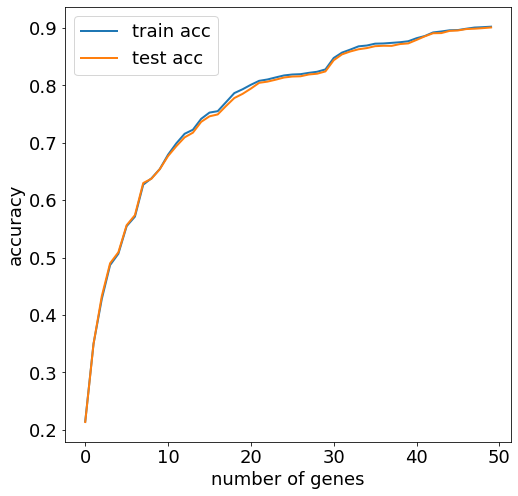

In [20]:
if __name__ == '__main__':
    t=Timer()
    t.start()
    feature_selected, num_samples_list, train_errors,test_errors,train_scores,test_scores= min_complexity(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples, balance=balance)
    t.stop()

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'genes_name',gene[feature_selected])

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")


# min_aquisition

## Define Parameters and Work Space

In [9]:
'''
Parameters
'''
num_features = 50
num_samples=30
init_samples=50

folder='results/min_acquisition'
path=folder+'/test_'+str(num_features)+'_'+str(num_samples)

try:
    os.mkdir('results')
except OSError:
    print ("Creation of the directory %s failed" % 'results')
else:
    print ("Successfully created the directory %s " % 'results')
try:
    os.mkdir(folder)
except OSError:
    print ("Creation of the directory %s failed" % folder)
else:
    print ("Successfully created the directory %s " % folder)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory results failed
Creation of the directory results/min_acquisition failed
Creation of the directory results/min_acquisition/test_50_30 failed


## Select Genes and Save Results

feature 0 : gene 290  50 samples
training error=491.3005120833708 test error=499.1498383039885
training accuracy=0.2676758602102237 test accuracy=0.26509162773984907
Elapsed time: 5.0210 seconds
feature 1 : gene 5611  50 samples
training error=427.3070478842871 test error=431.2699425080848
training accuracy=0.33485311292785913 test accuracy=0.33623787279913764
Elapsed time: 4.4871 seconds
feature 2 : gene 7369  50 samples
training error=418.46348037013746 test error=422.68145885734816
training accuracy=0.344645584403917 test accuracy=0.3452209845490478
Elapsed time: 5.1204 seconds
feature 3 : gene 1154  50 samples
training error=256.8733941245171 test error=253.65145526410348
training accuracy=0.41892013296199804 test accuracy=0.42346388789076533
Elapsed time: 5.0061 seconds
feature 4 : gene 1885  50 samples
training error=262.1268304734525 test error=259.2713798059648
training accuracy=0.4289821220016171 test accuracy=0.4316385195831836
Elapsed time: 4.9187 seconds
feature 5 : gene 42

Elapsed time: 11.0959 seconds
feature 42 : gene 846  97 samples
training error=50.93452969185159 test error=55.63492633848365
training accuracy=0.8929566076722666 test accuracy=0.8881602587136184
Elapsed time: 10.9526 seconds
feature 43 : gene 4733  97 samples
training error=50.40542179498697 test error=54.18154868846568
training accuracy=0.8945063336627437 test accuracy=0.890406036651096
Elapsed time: 12.1618 seconds
feature 44 : gene 4705  97 samples
training error=50.1894933069805 test error=53.828512396694215
training accuracy=0.8957640822926961 test accuracy=0.8913941789435861
Elapsed time: 12.3592 seconds
feature 45 : gene 5620  97 samples
training error=46.21298625460426 test error=50.77506288178225
training accuracy=0.9017159284880064 test accuracy=0.8973230326985268
Elapsed time: 13.7083 seconds
feature 46 : gene 5000  100 samples
training error=45.53236456742431 test error=49.68882500898311
training accuracy=0.9040068277782769 test accuracy=0.9009162773984908
Elapsed time: 14

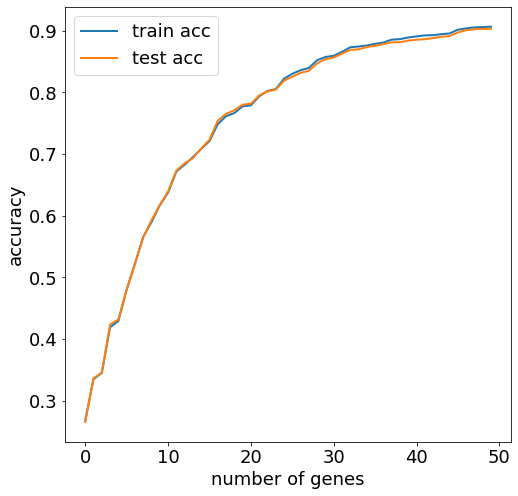

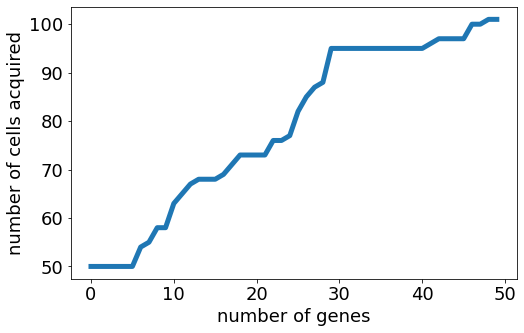

In [10]:
if __name__ == '__main__':
    t=Timer()
    t.start()
    feature_selected, num_samples_list, samples_global, train_errors,test_errors,train_scores,test_scores= min_acquisition(
        X_train,y_train,X_test,y_test,num_features=num_features,num_samples=num_samples,init_samples=init_samples)
    t.stop()

    text_create(path,'feature_selected',feature_selected)
    text_create(path,'error',train_errors+test_errors)
    text_create(path,'accuracy',train_scores+test_scores)
    text_create(path,'num_samples_list',num_samples_list)
    text_create(path,'samples_global',samples_global)
    text_create(path,'genes_name',gene[feature_selected])

    plt.figure(figsize=(8,8))
    plt.plot(train_scores,linewidth=2)
    plt.plot(test_scores,linewidth=2)
    plt.legend(['train acc','test acc'],prop = {'size':18})
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('accuracy',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/acc.pdf', bbox_inches="tight")

    plt.figure(figsize=(8,5))
    plt.plot(num_samples_list,linewidth=5)
    plt.xlabel('number of genes',fontdict={'weight':'normal','size': 18})
    plt.ylabel('number of cells acquired',fontdict={'weight':'normal','size': 18})
    plt.tick_params(labelsize=18)
    plt.savefig(path+'/cells.pdf', bbox_inches="tight")

# T-SNE of Results

In [11]:
with open('tabula.pickle','rb') as handle:
    raw_data = pickle.load(handle)
    gene=np.array(pickle.load(handle))
    target=np.array(pickle.load(handle))

data_tmp=normalize(raw_data,axis=1, norm='l2')
alpha = 100
data = np.log1p(data_tmp*alpha).toarray().transpose()

del raw_data,data_tmp

print(np.shape(data),np.shape(target),len(np.unique(target)))

(55656, 8661) (55656,) 58


## T-SNE of Original Dataset

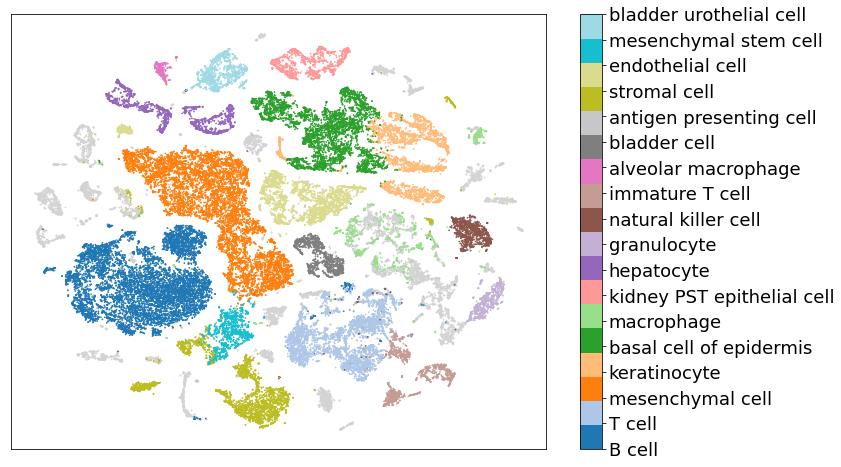

In [12]:
classes=[39,14,46,0,21,51,7,44,9,28,29,45,13,27,50,22,41,52]
keys=['B cell','T cell','mesenchymal cell','keratinocyte','basal cell of epidermis', 'macrophage','kidney PST epithelial cell', 'hepatocyte','granulocyte','natural killer cell','immature T cell','alveolar macrophage', 'bladder cell','antigen presenting cell','stromal cell','endothelial cell','mesenchymal stem cell','bladder urothelial cell']

idx=list([])
labels=target
for i in range(len(classes)):
    tmp=list(np.where(target==classes[i])[0])
    labels[tmp]=i+1
    idx =idx+ tmp
others=list(set(range(np.shape(data)[0])).difference(set(idx)))
labels[others]=-1

pca=PCA(n_components=int(X_train.shape[1]/100),
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data)
Y=TSNE(n_components=2).fit_transform(pcaproj)

plt.figure(figsize=(12,8))
c_cmap = plt.get_cmap('tab20', len(classes))
plt.scatter(Y[others,0], Y[others,1], c='lightgray', s= 0.5) # plot all cells as background
plt.scatter(Y[idx,0], Y[idx,1], c=labels[idx], s=0.5,cmap=c_cmap) # plot subpopulation cells on top
cbar=plt.colorbar(ticks=np.arange(1,len(classes)+1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys,fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne.pdf',bbox_inches="tight")
import pickle
f=open(path+'/tsne.pickle','wb') 
pickle.dump(Y,f)
f.close()

## T-SNE with All Genes Selected

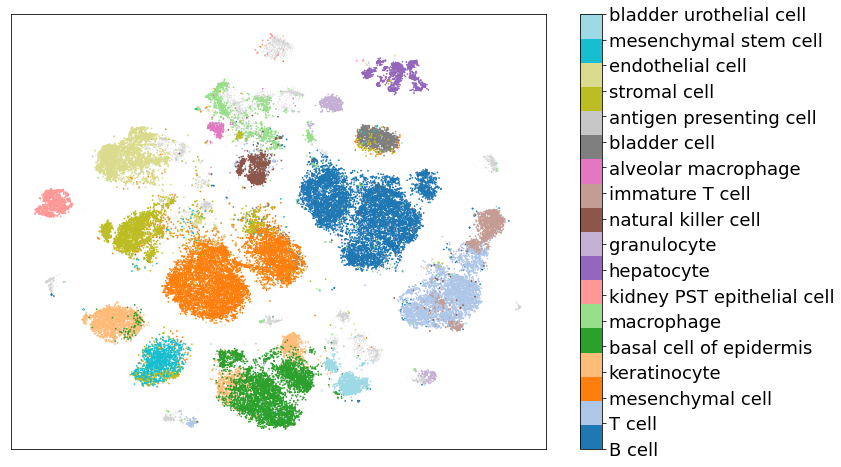

In [13]:
data_selected=data[:,feature_selected]

pca=PCA(n_components=10,
       copy=True,
       whiten=False,
       svd_solver='auto',
       tol=0.0,
       iterated_power='auto',
       random_state=None)
pcaproj=pca.fit_transform(data_selected)

Y_selected=TSNE(n_components=2,perplexity=200,early_exaggeration=1).fit_transform(pcaproj)

plt.figure(figsize=(12,8))

c_cmap = plt.get_cmap('tab20', len(classes))
plt.scatter(Y_selected[others,0], Y_selected[others,1], c='lightgray', s= 0.01) # plot all cells as background
plt.scatter(Y_selected[idx,0], Y_selected[idx,1], c=labels[idx], s=0.5,cmap=c_cmap) # plot subpopulation cells on top
cbar=plt.colorbar(ticks=np.arange(1,len(classes)+1))
plt.xticks([])
plt.yticks([])
cbar.ax.set_yticklabels(keys,fontdict={'weight':'normal','size': 18})
plt.savefig(path+'/tsne_selected_wpca.pdf',bbox_inches="tight")
import pickle
f=open(path+'/tsne_selected_wPCA.pickle','wb') 
pickle.dump(Y_selected,f)
f.close()

## T-SNE of Each Gene

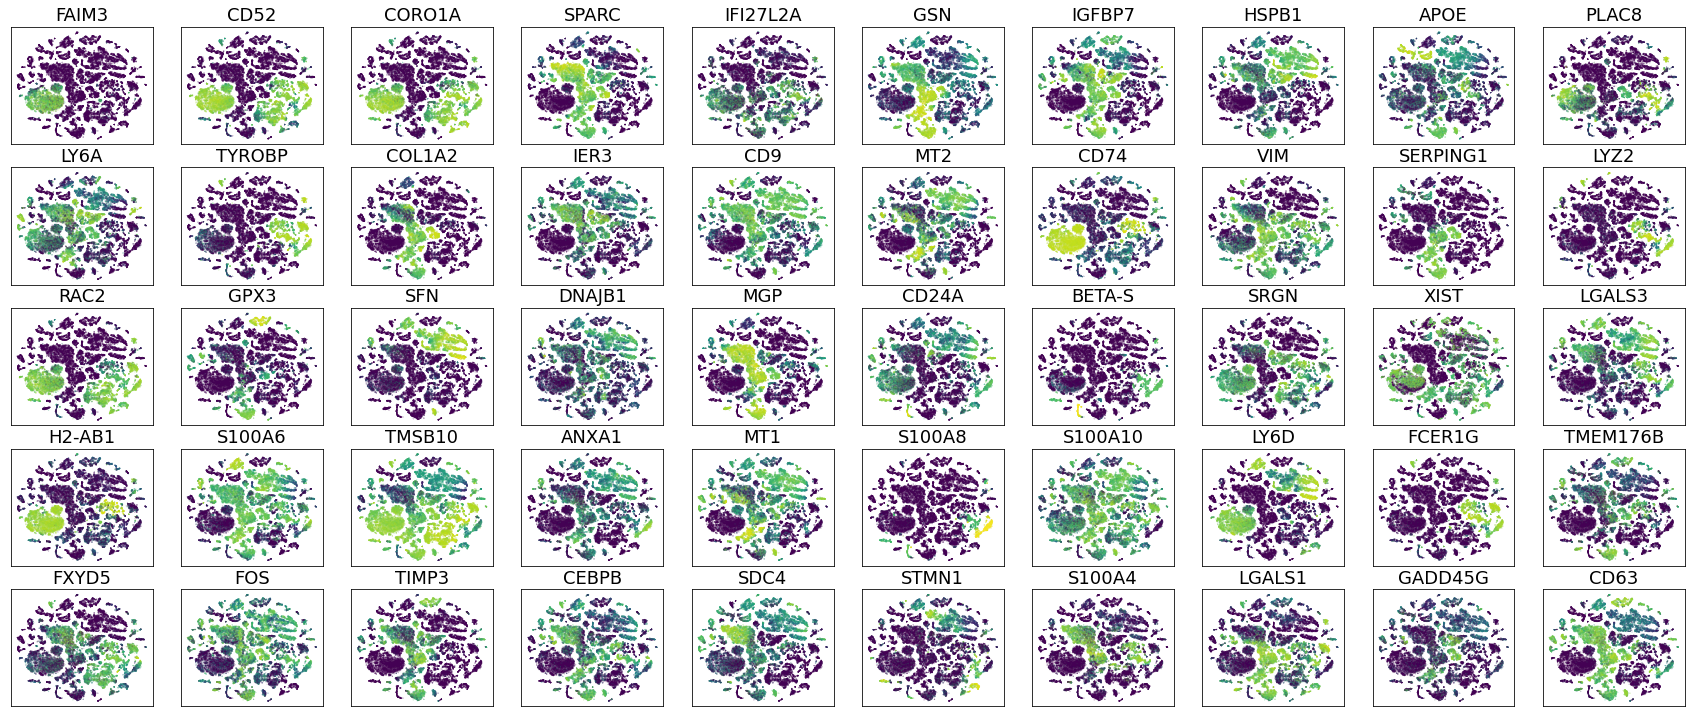

In [17]:

size=len(feature_selected)
plt.figure(figsize=(30,0.25*size))
gs = gridspec.GridSpec(int(size/10), 10, width_ratios=[7,7,7,7,7,7,7,7,7,7])

for i in range(size):
    f=feature_selected[i]
    ax0 = plt.subplot(gs[i])
    ax0.set_title(gene[f],fontdict={'weight':'normal','size': 18})
    plt.scatter(Y[:,0],Y[:,1],c=data[:,f],s=0.005)
    ax0.set_xticks([])
    ax0.set_yticks([])
plt.savefig(path+'/gene.png',dpi=300,  bbox_inches="tight")    